In [12]:
%load_ext autoreload
%autoreload 2

import cv2
import os
import numpy as np
import matplotlib
import tkinter
import matplotlib.pyplot as plt
import random
# matplotlib.use('TkAgg')
# %matplotlib widget
%matplotlib inline 
from PIL import Image
import IPython

import pyrealsense2 as rs                 # Intel RealSense cross-platform open-source API
from stretch_body.robot import Robot
from scipy.spatial.transform import Rotation
from re1_utils.camera import get_cur_rs_frame
from re1_utils.objdet_utils import plot_all_boxes


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**Object Detection**: From yolov7

In [3]:
import sys
sys.path.append('./yolov7/')
from yolov7.predict import load_model, preprocessing, \
    postprocessing, load_config

In [4]:
#Load config from yaml
CONFIG_PATH = './yolov7/predict_config.yaml'
config_dict = load_config(CONFIG_PATH)

#Load model, edit yolov7.pt path
model, stride, device = load_model(config_dict, '../yolov7/yolov7.pt')


[INFO] [utils.torch_utils]: YOLOR 🚀 a0bbdb1 torch 1.12.1+cu102 CPU



Fusing layers... 


[INFO] [utils.torch_utils]: Model Summary: 306 layers, 36905341 parameters, 36905341 gradients


RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block


Read sample img

In [5]:
#Read img0 to BGR
img0 = cv2.imread('./yolov7/inference/images/image1.jpg')
# img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB)
#Resize, pad
img = preprocessing(config_dict, img0, stride, device) 

#Inference
pred = model(img, augment=config_dict['augment'])[0] #Shape (1, num_preds, 85)

#nms and scale coordinates
pred = postprocessing(config_dict, pred, img0.shape, img.shape)

#xyxy, conf_score, class
print(pred, pred.shape)

[[        250          78         633         531     0.96753           0]
 [          2           5         402         527     0.95566           0]
 [        196         199         254         418     0.88187          27]
 [        256         207         299         247     0.42756          55]] (4, 6)


/home/hello-robot/anaconda3/envs/RE1/lib/python3.8/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


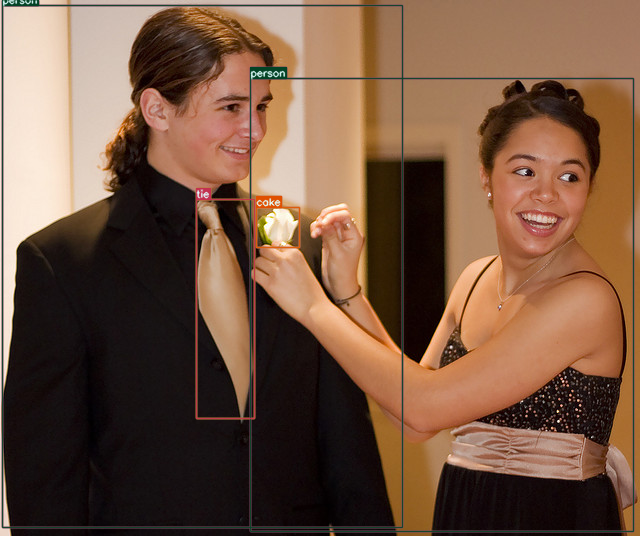

In [8]:
img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB)

plot_all_boxes(pred, img0)
# plt.imshow(img0)
# plt.show()

# img = Image.fromarray(img0, 'RGB')
# img.show()

IPython.display.display(Image.fromarray(img0))



In [13]:
color_frame, color, depth_frame, depth = get_cur_rs_frame()

Frames Captured


[[        332         464         381         596     0.88139          39]
 [        201         454         245         599     0.86773          39]
 [        168         236         204         346     0.50883          39]] (3, 6)


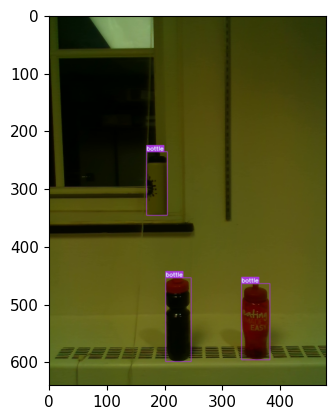

In [15]:
from re1_utils.objdet_utils import plot_all_boxes

#Resize, pad
color_img = preprocessing(config_dict, color, stride, device) 

#Inference
pred = model(color_img, augment=config_dict['augment'])[0] #Shape (1, num_preds, 85)

#nms and scale coordinates
pred = postprocessing(config_dict, pred, color.shape, color_img.shape)

#xyxy, conf_score, class
print(pred, pred.shape)
color = np.ascontiguousarray(color, dtype=np.uint8)

plot_all_boxes(pred, color)
# color_img = Image.fromarray(color, 'RGB')
# color_img.show()
plt.imshow(color)
plt.show()


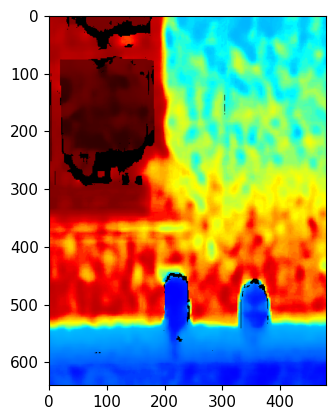

In [17]:
from re1_utils.camera import get_rs_colorized_depth
colorized_depth = get_rs_colorized_depth(depth_frame=depth_frame)
# depth_img = Image.fromarray(colorized_depth, 'RGB')
# depth_img.show()
plt.imshow(colorized_depth)
plt.show()

**Testing landmark screen**

In [21]:
from re1_utils.camera import get_cur_rs_frame
color_frame, color, depth_frame, depth = get_cur_rs_frame()
color = np.ascontiguousarray(color, dtype=np.uint8)


Frames Captured


In [22]:
from POI.landmark_screen import LandmarkScreen


landmark_screen = LandmarkScreen(color_frame=color, depth_frame=depth)
landmark_screen.update_OOI(pred)
landmark_screen.show()
landmark_screen.show_OOI()

bottle at ((332, 464), (381, 596)) depth 1.308000087738037 meters
bottle at ((201, 454), (245, 599)) depth 1.249000072479248 meters
bottle at ((168, 236), (204, 346)) depth 1.3020000457763672 meters


**Test Intrinsic Matrix**

In [23]:
#Test intrinsic matrix
from re1_utils.camera import get_rs_intrinsic_mat
intrinsic_mat = get_rs_intrinsic_mat()
print(intrinsic_mat)
inv_intrinsic_mat = np.linalg.inv(intrinsic_mat)
print(inv_intrinsic_mat)


[[     606.46           0      323.98]
 [          0       606.4      234.81]
 [          0           0           1]]
[[  0.0016489           0     -0.5342]
 [          0   0.0016491    -0.38722]
 [          0           0           1]]


In [24]:
from POI.landmark_screen import LandmarkScreen

landmark_screen.update_cam_coords(inv_intrinsic_mat)

In [25]:
#Please edit index
bottle0 = landmark_screen.get_OOI()[0]
bottle0.show()
bottle1 = landmark_screen.get_OOI()[1]
bottle1.show()

bottle at ((332, 464), (381, 596)) depth 1.308000087738037 meters
bottle at ((201, 454), (245, 599)) depth 1.249000072479248 meters


In [27]:
print(bottle0.img_coord, bottle0.cam_coord)
print(bottle1.img_coord, bottle1.cam_coord)


[      356.5         530           1] [   0.070148     0.63672       1.308]
[        223       526.5           1] [   -0.20796     0.60079       1.249]


**Test extrinsic matrix**

In [28]:
#Test intrinsic matrix
from re1_utils.camera import get_rs_extrinsic_mat
extrinsic_mat = get_rs_extrinsic_mat(type = 'cam2base')
print(extrinsic_mat)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[[    0.99935   -0.030682    0.018945    0.012751]
 [   0.019469    0.016869    -0.99967    0.016636]
 [   0.030352     0.99939    0.017455      1.2293]
 [          0           0           0           1]]


In [29]:
from POI.landmark_screen import LandmarkScreen

landmark_screen.update_base_coords(extrinsic_mat)

In [31]:
print(bottle0.cam_coord, bottle0.base_coord)
print(bottle1.cam_coord, bottle1.base_coord)

[   0.070148     0.63672       1.308] [   0.088098      1.8906      1.2788]
[   -0.20796     0.60079       1.249] [   -0.18984      1.8452      1.2259]


In [ ]:
# sys.path.append('..')

In [ ]:
# from POI.object_of_interest import OOI
# all_objects = []
# for i in range(pred.shape[0]):
#     coord = pred[i, :]
#     obj = OOI(
#         img_coord = np.array([(coord[2]+coord[0])/2,(coord[3]+coord[1])/2]), 
#         depth = 0,
#         obj_class = int(coord[-1]),
#         obj_atributes = 'None', 
#         bbox = ((coord[0],coord[1]),(coord[2],coord[3])),
#         conf_score = coord[4],
#         eid = i
#     )
#     all_objects.append(obj)

MEMORY

*Taken from fairo tutorial and memory module


**Memory**

Now we have setup a small object detection + deduplication pipeline.

But the robot is not storing the information of these objects in it's memory yet.

If it doesn't store this information in memory, then when you say "go to the chair", it does not know where the chair is (unless the chair is in it's field of view at that given moment).

`droidlet` provides a memory system that can store generic metadata. This memory system is used by the Dialog Parser + Task controller to do tasks utilizing context provided by information stored in memory.

The memory is backed by an SQL database, and has schemas to represent common semantic information for robots and the environment.

Let us first create the default `AgentMemory` object for our Locobot using some pre-baked and thoughtful memory schemas.

In [ ]:
sys.path.append('./memory/')


In [ ]:
from memory.sql_memory import AgentMemory
from memory.robot.loco_memory_nodes import NODELIST

SQL_SCHEMAS = [
    os.path.join(os.getcwd(), "memory", "base_memory_schema.sql"),
    os.path.join(os.getcwd(), "memory", "robot","loco_memory_schema.sql"),
]

In [ ]:
memory = AgentMemory(db_file=":memory:", schema_paths=SQL_SCHEMAS, nodelist=NODELIST)

We can see the types of nodes that can be stored inside the memory

In [ ]:
memory.nodes

Let us store the previously detected objects into memory, using this new memory system.

For this, we will use the DetectedObjectNode. A physical object is represented in memory as a DetectedObjectNode, which is thoughtfully annotated with properties such as it's color and it's detected xyz location.

As a reminder, in the previous section, we deduplicated the objects detected in the scene, and stored them in the variable previous_objects.

Now, we will store these all_objects into the memory. Let us start with storing and retreiving one object, and inspecting the results.

In [ ]:
# from memory.robot.loco_memory_nodes import Detect
from memory.robot.loco_memory_nodes import BCIDetectedObjectNode


In [ ]:
memory_ids = []
for i in range(len(all_objects)):
    memory_id = BCIDetectedObjectNode.create(memory, all_objects[i])
    memory_ids.append(memory_id)

Now, let us retreive the `DetectedObjectNode` from memory.

In [ ]:
memory.get_mem_by_id(memory_id)

The memory object is in it's raw packed form, and is not yet converted back to a dict with accessible fields.

We can access the detected objects back from memory as dicts using the `get_all` function:

In [ ]:
BCIDetectedObjectNode.get_all(memory)

Now, let us store the rest of the detected objects into memory